In [4]:
# https://huggingface.co/intfloat/multilingual-e5-large/tree/main#/
import os
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch.nn.functional as F

import numpy as np
from torch import Tensor
from transformers import AutoTokenizer, AutoModel




# 将“query：”和“passage：”对非对称任务相应地使用，例如开放式QA中的段落检索、临时信息检索。
# 对称任务使用“query：”前缀，例如语义相似性、双文本挖掘、释义检索。
# 如果要将嵌入用作特征，请使用“query：”前缀，例如线性探测分类、聚类。
# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = [
    # '先生',"男人","父亲",
#  '女士',"女人", "母亲 "


    # '先生',"男人","父亲","男","帅哥","小伙",
#  '女士',"女人", "母亲 ","女","美女","姑娘"
"男孩","爸爸","皇帝","父亲","爷爷","孙子","新郎","丈夫","男人","侄子","王子","儿子","继父","叔叔", 
"女孩","妈妈","皇后","母亲","奶奶","孙女","新娘","妻子","女人","侄女","公主","女儿","继母","阿姨"
]


tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
# batch_dict.keys()  dict_keys(['input_ids', 'attention_mask'])
# batch_dict['input_ids'].shape  torch.Size([46, 5])
# batch_dict['attention_mask'].shape  # torch.Size([46, 5])
# tensor([[     0,      6,  72853,      2,      1],
#         [     0,      6,  49790,      2,      1],
#         [     0,      6,  35023,      2,      1],
#         [     0,      6, 180883,      2,      1],
# batch_dict['attention_mask']
# tensor([[1, 1, 1, 1, 0],
#         [1, 1, 1, 1, 0],

outputs = model(**batch_dict)

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)  #torch.Size([40, 1024])

#保存 embeddings
np.save('embeddings.npy', embeddings.cpu().detach().numpy())

*************************************mode: Diff Dist 0.1


100%|██████████| 196/196 [00:04<00:00, 44.89it/s]


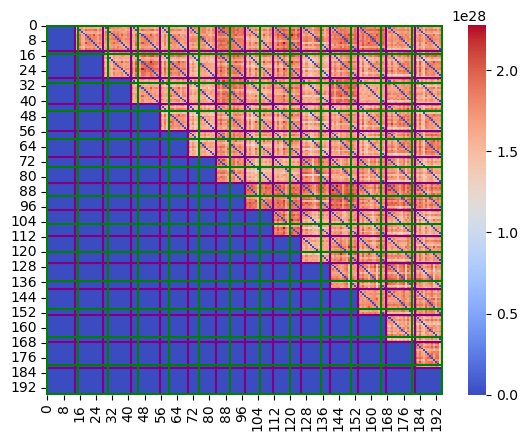

10372
*************************************mode: Diff Dist 0.2


100%|██████████| 196/196 [00:04<00:00, 44.10it/s]


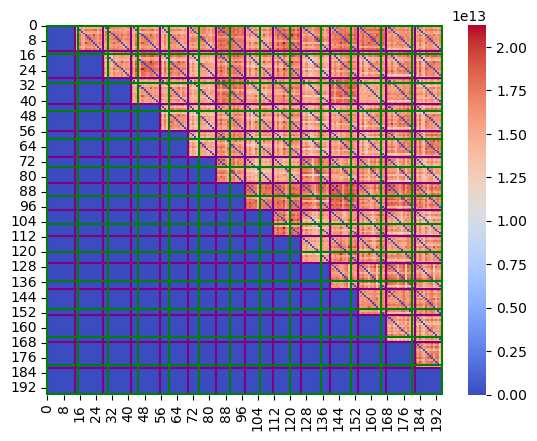

10296
*************************************mode: Diff Dist 0.30000000000000004


 91%|█████████ | 178/196 [00:03<00:00, 44.53it/s]


KeyboardInterrupt: 

In [15]:
# 读取 
import Hlib
import numpy as np
import torch
embeddings = np.load('embeddings.npy')
# 转为 tensor
embeddings = torch.tensor(embeddings)

for i,j in Hlib.vector_modes.items():
    for ii,jj in Hlib.diff_modes.items():
        # p的范围从0.1 至 5 步长为0.1
        for p in np.arange(0.1,5,0.1):
            if i== "Cross" and ii == "JaccardSimilarity":
                continue
            out,nonSample,trSample = Hlib.plt_seaborn(embeddings,i,ii,p=p,isplt = False,Absolute=True,reversal = False,mulmermod = 1)
            a,b = Hlib.find_ordered_positions(nonSample, trSample)
            # 只保留数组b，长度的前70%个元素
            b = b[:int(len(b)*0.7)]
            # 求和
            print(sum(b))



        



In [14]:
import numpy as np
embeddings = np.load('embeddings.npy')
v1 = np.array([ 0.03228169,  0.00767738 ])
v2 = np.array([0.02560907,  0.02904721])
def JaccardSimilarity(v1, v2):
    v1 = v1.flatten().tolist()
    v2 = v2.flatten().tolist()
    return len(set(v1) & set(v2)) / len(set(v1) | set(v2))

a= JaccardSimilarity(v1,v2)
a

0.0